In [1]:
import os
os.chdir("../")
import torch


import GCAST
os.environ["R_HOME"] = "/public/home/ljquan/anaconda3/envs/myx/lib/R"
random_seed = 2025
device = "cuda" if torch.cuda.is_available() else "cpu"
packnames = ('mclust',)



/public/home/ljquan/anaconda3/envs/myx/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


### Preprocess on the mouse embryo dataset at the three developmental timepoints
Note: this step is performed without position alignment.

In [2]:
data_root = "../test/Dataset/Mouse/Mouse_EMbryo"
sample_name = ["MouseCrossTime"]*3 
file_name = [
    "E9.5_E1S1.MOSTA.h5ad", 
    "E10.5_E2S1.MOSTA.h5ad",
    "E11.5_E1S3.MOSTA.h5ad",
]
tech_lst = ["Stereo-seq", "Stereo-seq", "Stereo-seq" ]
Hist = [ False, False, False]
subsample = [2500, 2500, 5000]

n_clusters= 12
negi = 12


In [3]:
GCAST.set_seed(random_seed)
adata, graph_dict = GCAST.LoadCrossST(data_root, sample_name, file_name, n_clusters,tech_lst,subsample, Hist, n_top_genes=6000).data()
net = GCAST.GCAST(adata.obsm["X_pca"], graph_dict, device=device,model_path= f"{data_root}", model_name=f"MouseEmbryo")

100%|██████████| 3/3 [00:15<00:00,  5.07s/it]


In [4]:
net.train_with_dec()

 21%|██▏       | 213/1000 [04:01<14:52,  1.13s/it]


## Extract embedding for Cross-temporal integration of Mouse Embryo dataset
> **Note:**   
> (1) After loading the `adata` object and the graph using `LoadCrossST()`, you can skip the `train_with_dec()` step.   
> (2) The related data and **pretrained model** `MouseEmbryo.pth` are available at the following link:   
> https://pan.quark.cn/s/fa511e11c294 (in fold `../Dataset/Mouse/Mouse_EMbryo/`).   
> (3) By loading the trained weights in `MouseEmbryo.pth` and setting the network to evaluation mode (`net.eval()`), you can automatically reproduce the results in the paper.


In [5]:
adata.obsm["emb"] = net.eval()  
adata = GCAST.hm_integration(adata, harmony_key='emb')

2026-02-18 03:04:40,120 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2026-02-18 03:04:45,449 - harmonypy - INFO - sklearn.KMeans initialization complete.
2026-02-18 03:04:45,488 - harmonypy - INFO - Iteration 1 of 10
2026-02-18 03:04:47,730 - harmonypy - INFO - Iteration 2 of 10
2026-02-18 03:04:51,414 - harmonypy - INFO - Iteration 3 of 10
2026-02-18 03:04:54,037 - harmonypy - INFO - Iteration 4 of 10
2026-02-18 03:04:56,227 - harmonypy - INFO - Iteration 5 of 10
2026-02-18 03:04:58,934 - harmonypy - INFO - Iteration 6 of 10
2026-02-18 03:05:01,841 - harmonypy - INFO - Iteration 7 of 10
2026-02-18 03:05:02,842 - harmonypy - INFO - Iteration 8 of 10
2026-02-18 03:05:03,713 - harmonypy - INFO - Iteration 9 of 10
2026-02-18 03:05:04,228 - harmonypy - INFO - Iteration 10 of 10
2026-02-18 03:05:05,581 - harmonypy - INFO - Converged after 10 iterations


In [7]:
GCAST.KMedoids_Cluster(adata_processed, n_clusters=n_clusters) 
GCAST.evaluate_cluster(adata_processed, method_name="KMedoids")

KMedoids ARI:0.3138 NMI:0.3923 AMI:0.3907 purity:0.5573, homogeneity:0.4110, completeness:0.3753, v_measure:0.3923


## Align the spatial position coordinates of two different sequencing technology  for visualization
Note: You can skip *train_with_dec()* and directly obtain the post-training, coordinate-aligned spatial transcriptomics data from the provided link for convenient visualization.

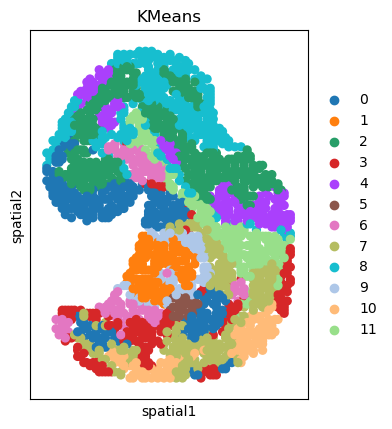

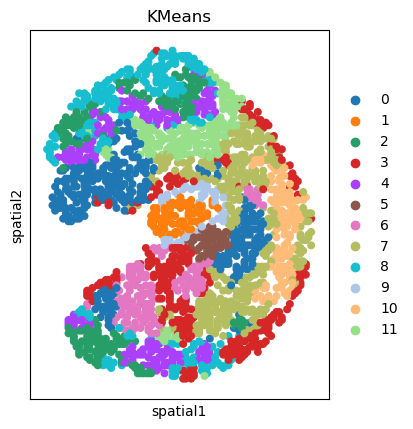

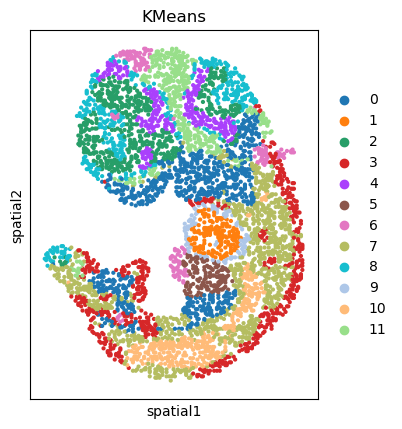

In [8]:
import anndata
import scanpy as sc 
import matplotlib.pyplot as plt
adata_processed = anndata.read_h5ad("../test/Dataset/Mouse/Mouse_EMbryo/adata_EmbyroTime.h5ad")  

batch_names = adata_processed.obs['batch_name'].unique()
for batch in batch_names:
    adata_batch = adata_processed[adata_processed.obs['batch_name'] == batch]
    if batch == "Mouse_Adult_Olfactory_Bulb_10x":
        batch_name = "Mouse Adult Olfactory(10x Visium)"
    elif batch == "Mouse_Olfactory_Stereo-seq":
        batch_name = "Mouse Adult Olfactory(Stereo-seq)"
    fig = sc.pl.spatial(
        adata_batch,
        color='KMeans',
        spot_size=3,
        return_fig=True  
    )

    fig.axes[0].set_title(f'{ batch} ', fontsize=20)


    plt.show()
    plt.close(fig)